['PodStartupLatency_PodStartupLatency_test_2021-12-09T18:35:32Z.json', 'PodStartupLatency_PodStartupLatency_test_2021-12-10T13:36:12Z.json', 'PodStartupLatency_PodStartupLatency_test_2021-12-10T15:58:21Z.json', 'PodStartupLatency_PodStartupLatency_test_2021-12-15T16:53:51Z.json', 'PodStartupLatency_PodStartupLatency_test_2022-01-05T16:46:04Z.json', 'PodStartupLatency_PodStartupLatency_test_2022-01-06T10:25:52Z.json', 'PodStartupLatency_PodStartupLatency_test_2022-01-06T17:12:01Z.json', 'PodStartupLatency_PodStartupLatency_test_2022-01-07T10:12:19Z.json']
Using results/PodStartupLatency_PodStartupLatency_test_2022-01-07T10:12:19Z.json
Missed metric: pod_startup
Missed metric: schedule_to_watch
Missed metric: create_to_schedule


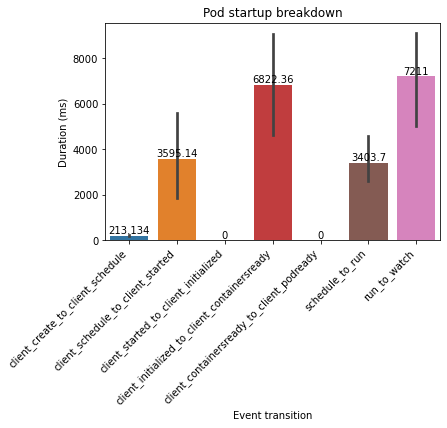

In [1]:
import matplotlib
import json
import seaborn
import pandas
import os

file = "PodStartupLatency_PodStartupLatency_test_2021-12-15T16:53:51Z.json"
file = f"results/{file}"

results = [f for f in os.listdir("results") if f.endswith("json") and f.startswith("PodStartupLatency")]
results.sort()
print(results)
file = f"results/{results[-1]}"
print(f"Using {file}")

j = json.loads(open(file, "r").read())

dataItems = j["dataItems"]

metrics = [
    "client_create_to_client_schedule",
    "client_schedule_to_client_started",
    "client_started_to_client_initialized",
    "client_initialized_to_client_containersready",
    "client_containersready_to_client_podready",
    # "create_to_schedule",  # time to write to etcd, pick up at scheduler and assign to node (write back to etcd)
    "schedule_to_run",  # time for node to pick up pod, pull image and get it running
    "run_to_watch",  # time from starting running for the observed status to be sent on a watch stream
    # "schedule_to_watch",  # time from it being scheduled until it is started and available to watch
    # "pod_startup",  # time for whole startup
]

for item in dataItems:
    if item["labels"]["Metric"] not in metrics:
        print(f"Missed metric: {item['labels']['Metric']}")

df = pandas.DataFrame()
for metric in metrics:
    found = False
    for item in dataItems:
        m = item["labels"]["Metric"]
        if m == metric:
            data = item["raw"]
            df[metric] = data
            found = True
    if not found:
        print(f"metric {metric} not found")

ax = seaborn.barplot(data=df)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Pod startup breakdown")
ax.set_xlabel("Event transition")
ax.set_ylabel("Duration (ms)")
fig = ax.get_figure()
fig.savefig("results/startup.pdf")
fig.savefig("results/startup.svg")
fig.savefig("results/startup.jpg")

In [207]:
import matplotlib
import json
import seaborn
import pandas as pd
import numpy as np
import os
from collections import defaultdict

In [158]:
results_options = [f"results/{f}" for f in os.listdir("results") if os.path.isdir(f"results/{f}")]
results_options.sort()
print("results dirs", results_options)

# results_dir = "results/2022-01-07T11:40:21+00:00"

results_dir = results_options[-1]

results dirs ['results/2022-01-07T10:54:42+00:00', 'results/2022-01-07T11:11:58+00:00', 'results/2022-01-07T11:12:10+00:00', 'results/2022-01-07T11:12:23+00:00', 'results/2022-01-07T11:14:00+00:00', 'results/2022-01-07T11:14:57+00:00', 'results/2022-01-07T11:15:09+00:00', 'results/2022-01-07T11:15:29+00:00', 'results/2022-01-07T11:40:21+00:00', 'results/2022-01-07T12:24:43+00:00', 'results/2022-01-07T12:30:51+00:00', 'results/2022-01-07T12:40:56+00:00', 'results/2022-01-07T12:46:12+00:00']


In [232]:
results = [f for f in os.listdir(results_dir) if f.endswith("json") and f.startswith("PodStartupLatency")]
configs = [f for f in os.listdir(results_dir) if f.endswith("json") and f.startswith("config")]

results.sort()
configs.sort()

df = pd.DataFrame()
for (config, r) in zip(configs, results):
    with open(f"{results_dir}/{config}", "r") as c:
        with open(f"{results_dir}/{r}") as r:
            
            config_json = json.loads(c.read())
            results_json = json.loads(r.read())
            
            rows_json = defaultdict(list)

            for item in results_json["dataItems"]:
                name = item["labels"]["Metric"]
                data = item["raw"]
                rows_json["metric"] += [name for _ in range(len(data))]
                rows_json["measurement"] += data

            for k, v in config_json.items():
                rows_json[k] = [v for _ in range(len(rows_json["metric"]))]
            
            d = pd.DataFrame(rows_json)
            df = df.append(d, ignore_index=True)
    
df.describe()

,measurement
count,1200.000000
mean,1324.271014
std,1470.636809
min,0.000000
25%,0.000000
50%,1000.000000
75%,2360.207190
max,6596.824459


In [260]:
df.head()

,metric,measurement,delay
0,client_containersready_to_client_podready,0.0,0
1,client_containersready_to_client_podready,0.0,0
2,client_containersready_to_client_podready,0.0,0
3,client_containersready_to_client_podready,0.0,0
4,client_containersready_to_client_podready,0.0,0


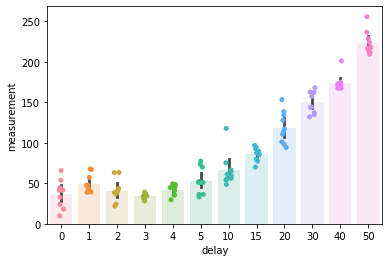

In [261]:
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]

ax = seaborn.stripplot(data=data, x="delay", y="measurement")
ax = seaborn.barplot(data=data, x="delay", y="measurement", alpha=0.2)

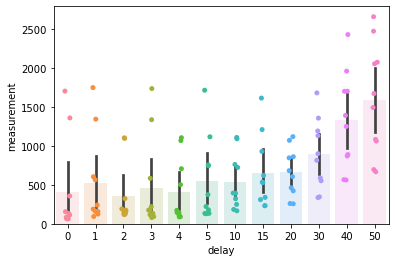

In [262]:
data = df[np.isin(df.metric, ["client_schedule_to_client_started"])]

ax = seaborn.stripplot(data=data, x="delay", y="measurement")
ax = seaborn.barplot(data=data, x="delay", y="measurement", alpha=0.2)

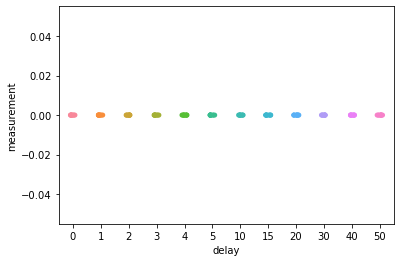

In [263]:
data = df[np.isin(df.metric, ["client_started_to_client_initialized"])]

ax = seaborn.stripplot(data=data, x="delay", y="measurement")
ax = seaborn.barplot(data=data, x="delay", y="measurement", alpha=0.2)

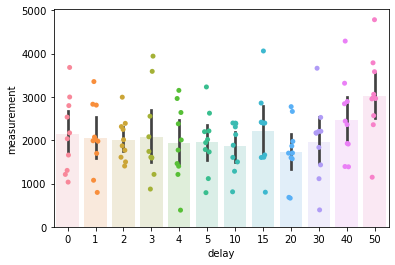

In [264]:
data = df[np.isin(df.metric, ["client_initialized_to_client_containersready"])]

ax = seaborn.stripplot(data=data, x="delay", y="measurement")
ax = seaborn.barplot(data=data, x="delay", y="measurement", alpha=0.2)

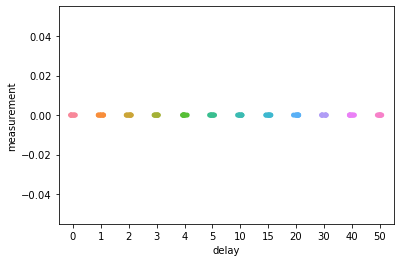

In [265]:
data = df[np.isin(df.metric, ["client_containersready_to_client_podready"])]

ax = seaborn.stripplot(data=data, x="delay", y="measurement")
ax = seaborn.barplot(data=data, x="delay", y="measurement", alpha=0.2)